In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

In [31]:
blacklist = pd.read_csv('host_detections.csv')
blacklist.head()

,host,listOfDetections,count
0,011rtr6kjtjdrhkyl68pkrjthbdfntmk.servehttp.com,0,0
1,02b123c.netsolhost.com,0,0
2,0hb.ru,"[u'MyWOT', u'SURBL', u'BitDefender']",3
3,0lilioo0l0o00lilil.info,"[u'MyWOT', u'SCUMWARE', u'SURBL', u'hpHosts', ...",7
4,0n1u4og97yt85sy8faitxwt.addirectory.org,0,0


In [3]:
blacklist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9836 entries, 0 to 9835
Data columns (total 3 columns):
host                9836 non-null object
listOfDetections    9836 non-null object
count               9836 non-null int64
dtypes: int64(1), object(2)
memory usage: 230.6+ KB


## Let's check how many unique detections do we have

In [4]:
def proccess(X):
    X = "".join(X.split(','))
    X = X.replace("u'",'')
    X = re.sub(r'[^\w\s]','',X).split(' ')
    return X

In [8]:
blacklist['new_col'] = blacklist['listOfDetections'].apply(proccess)
blacklist.head()

s = blacklist.apply(lambda x: pd.Series(x['new_col']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'detections'

df = blacklist.drop(['listOfDetections', 'new_col'], axis = 1).join(s)
df.head()

,host,count,detections
0,011rtr6kjtjdrhkyl68pkrjthbdfntmk.servehttp.com,0,0
1,02b123c.netsolhost.com,0,0
2,0hb.ru,3,MyWOT
2,0hb.ru,3,SURBL
2,0hb.ru,3,BitDefender


In [9]:
print('There are {} unique detections.'.format(df['detections'].nunique()))
print(df['detections'].unique())

There are 31 unique detections.
['0' 'MyWOT' 'SURBL' 'BitDefender' 'SCUMWARE' 'hpHosts' 'DrWeb'
 'GoogleSafeBrowsing' 'DNSBH' 'SpamhausDBL' 'BrowserDefender' 'Avira'
 'None' 'DShield' 'MalwareDomainList' 'YandexSafeBrowsing' 'Sucuri'
 'urlQuery' 'AVGThreatLabs' 'z_protect' 'ThreatLog' 'URLVir' 'Quttera'
 'MalwarePatrol' 'CRDF' 'Fortinet' 'ZeuS' 'Tracker' '' 'Malc0de'
 'PhishTank']


In [12]:
piv1 = df.groupby('detections')['host'].count().reset_index().sort_values('host', ascending = False)
piv1

,detections,host
1,0,7288
4,BitDefender,1426
15,MyWOT,941
11,GoogleSafeBrowsing,590
19,SCUMWARE,557
20,SURBL,412
2,AVGThreatLabs,288
16,None,235
21,SpamhausDBL,228
5,BrowserDefender,228


In [21]:
# Let's delete rows with values equal to 0, empty values and None
df = df[df['detections']!='0']
df = df[df['detections']!='None']
df = df[df['detections']!='']

# max list
blacklist = blacklist[blacklist['listOfDetections']!='0']
blacklist = blacklist[blacklist['listOfDetections']!='None']
blacklist = blacklist[blacklist['listOfDetections']!='']
max_count = blacklist['host'].count()

piv1 = df.groupby('detections')['host'].count().reset_index().sort_values('host', ascending = False)
piv1['percent'] = round((piv1['host']/max_count)*100,2)
piv1

,detections,host,percent
2,BitDefender,1426,55.97
13,MyWOT,941,36.93
9,GoogleSafeBrowsing,590,23.16
16,SCUMWARE,557,21.86
17,SURBL,412,16.17
0,AVGThreatLabs,288,11.30
3,BrowserDefender,228,8.95
18,SpamhausDBL,228,8.95
7,DrWeb,181,7.10
5,DNSBH,178,6.99


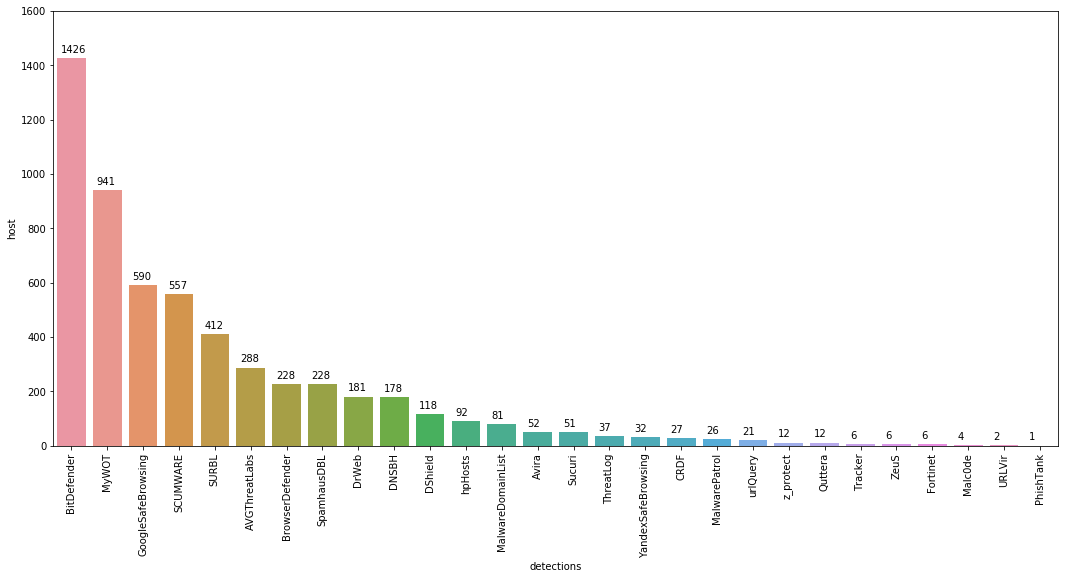

In [24]:
plt.figure(figsize=(18,8))
plt.xticks(rotation = 90)
ax = sns.barplot(x='detections', y='host', data=piv1)
ax.set(ylim = (0, 1600))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+0.1,height+20, '%.0f'%(height))
plt.show()

## Let's check our domains

In [25]:
df['domains'] = df['host'].apply(lambda x: x.split('.')[-1])
df.head()

,host,count,detections,domains
2,0hb.ru,3,MyWOT,ru
2,0hb.ru,3,SURBL,ru
2,0hb.ru,3,BitDefender,ru
3,0lilioo0l0o00lilil.info,7,MyWOT,info
3,0lilioo0l0o00lilil.info,7,SCUMWARE,info


In [27]:
piv2 = df.groupby('domains')['host'].count().reset_index().sort_values('host', ascending = False)
piv2['percent'] = round((piv2['host']/max_count)*100,2)
piv2

,domains,host,percent
15,com,1922,75.43
53,ru,580,22.76
56,tk,470,18.45
33,info,395,15.50
43,net,314,12.32
47,org,258,10.13
32,in,220,8.63
12,cc,189,7.42
8,biz,120,4.71
44,nl,77,3.02


In [28]:
piv3 = df.groupby(['domains', 'detections'], as_index = False)['count'].sum().sort_values('count', ascending = False)
piv3.head(20)

,domains,detections,count
107,com,MyWOT,1105
96,com,BitDefender,994
109,com,SCUMWARE,879
103,com,GoogleSafeBrowsing,712
110,com,SURBL,526
369,ru,MyWOT,511
371,ru,SURBL,378
390,tk,MyWOT,331
391,tk,SURBL,323
97,com,BrowserDefender,317


In [29]:
# Let's make some df with top 5 domains for detections with more than 100 observations
df2 = pd.DataFrame(columns = ['domains','detections', 'count'])

uniq = piv1[piv1['host']>100]['detections'].unique()

for word in uniq:
    time_df = piv3[piv3['detections'] == word].sort_values('count', ascending = False).head()
    df2 = pd.concat([df2,time_df])

df2

,domains,detections,count
96,com,BitDefender,994
385,tk,BitDefender,270
361,ru,BitDefender,224
280,net,BitDefender,164
314,org,BitDefender,161
107,com,MyWOT,1105
369,ru,MyWOT,511
390,tk,MyWOT,331
219,info,MyWOT,225
289,net,MyWOT,169


In [34]:
blacklist.head(1130)

,host,listOfDetections,count
0,011rtr6kjtjdrhkyl68pkrjthbdfntmk.servehttp.com,0,0
1,02b123c.netsolhost.com,0,0
2,0hb.ru,"[u'MyWOT', u'SURBL', u'BitDefender']",3
3,0lilioo0l0o00lilil.info,"[u'MyWOT', u'SCUMWARE', u'SURBL', u'hpHosts', ...",7
4,0n1u4og97yt85sy8faitxwt.addirectory.org,0,0
5,0td4nbde7.ttl60.com,"[u'SpamhausDBL', u'BitDefender']",2
6,0v2.info,0,0
7,0wu.ru,0,0
8,0y1.ru,0,0
9,10056.r.gd,"[u'MyWOT', u'BitDefender', u'BrowserDefender']",3
